<a href="https://colab.research.google.com/github/mangrue/FakeNewsDetection-CrossModelsDatasets/blob/main/1_FakeNewsDetection_CrossModelsDatasets_FinalDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Setting up environment**

In [1]:
# Install specific libraries
#! pip install torch
#! pip install transformers
#! pip install pycaret
#! pip install pandas
#! pip install numpy
#! pip install pycaret
#! pip install matplotlib
#! pip install -U scikit-learn
#! pip install transformers==2.8.0
#!pip install --upgrade huggingface_hub
!pip install evaluate -q
!pip install datasets -q

import numpy as np
import pandas as pd
#import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import BertTokenizer, BertForMaskedLM
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

# Set Working Directory - if working on Google Drive
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/MyDrive #/Colab_Notebooks


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
Mounted at /content/drive


#**Load and prepare dataset(s) - generating 'final' versions**

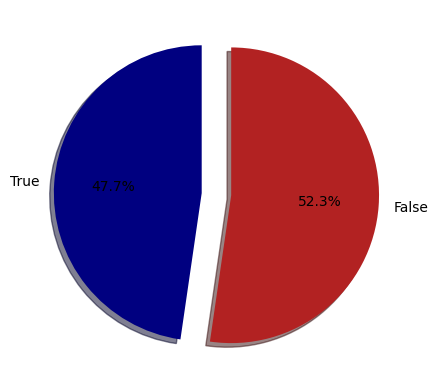

In [ ]:
#==============================================================================================================================
#ISOT
#==============================================================================================================================

# Load dataset
true_data = pd.read_csv('/content/drive/MyDrive/DATASETS/ISOT_News_dataset/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/DATASETS/ISOT_News_dataset/Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['label'] = ['True']*len(true_data)
fake_data['label'] = ['False']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = true_data._append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

# Label column is made of string values True/Fake, let's change it to numbers 0/1 (TRUE=1)
data['label'] = pd.get_dummies(data.label)['True']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

#print(data)

df = pd.DataFrame(data)

df['text'] = df['title'] + '\n\n' + df['text']
finaldf = df[['text', 'label']]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/ISOT_final.csv", sep=',', index=False, encoding='utf-8')

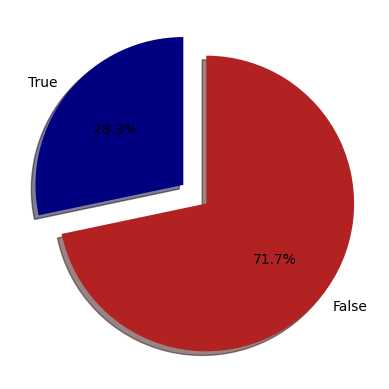

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#==============================================================================================================================
#NELA-GT-2018
#==============================================================================================================================

# Load dataset
from datasets import load_dataset
import sqlite3
#import create_engine from sqlalchemy
#from sqlalchemy import create_engine
#import pandas
import pandas as pd

#read database using create_engine
dbfile = '/content/drive/MyDrive/DATASETS/NELA-GT-2018/nela-gt-2018.db'
con = sqlite3.connect(dbfile)

# creating cursor
#cur = con.cursor()

# reading all table names
#table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
#print(table_list)

#takes about 5-6 mins due to large size of dataset
df = pd.read_sql_query("SELECT source, title, content FROM newsdata LIMIT 162411", con) #LIMIT to 20% of overall dataset (812 057) # ADJUST!!!!! ###############################################################################
#print(df)

# Be sure to close the connection
con.close()

df_labels = pd.read_csv("/content/drive/MyDrive/DATASETS/NELA-GT-2018/labels.csv", sep = ',', header=None)
df_labels = df_labels.drop(df_labels.index[0])
df_labels.columns = ['source', 'label']
#0 - reliable (TRUE), 1 - mixed (MIXED), 2 - unreliable (FALSE)
#df_labels = df_labels.drop(df_labels[df_labels['label'] == '1'].index)
df_labels.loc[df_labels.label == "0", 'label'] = "TRUE"
df_labels.loc[df_labels.label == "1", 'label'] = "MIXED"
df_labels.loc[df_labels.label == "2", 'label'] = "FALSE"
#print(df_labels)

df_merged = df.merge(df_labels, on = 'source', how = 'outer')
df_merged = df_merged.drop('source', axis=1)
df_merged = df_merged.drop(df_merged[df_merged['label'] == 'MIXED'].index)
df_merged = df_merged.rename(columns={"content": "text"})
#print(df_merged)

data = df_merged

# Label column is made of string values True/Fake, let's change it to numbers 0/1 (TRUE=1)
data['label'] = pd.get_dummies(data.label)['TRUE']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

#print(data)

df = pd.DataFrame(data)

df['text'] = df['title'] + '\n\n' + df['text']
finaldf = df[['text', 'label']]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

#Check if None values exist in rows
#null_mask = finaldf.isnull().any(axis=1)
#null_rows = finaldf[null_mask]
#print(null_rows)

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/NELA-GT-2018_final.csv", sep=',', index=False, encoding='utf-8')

#Remove 'None' again
dataset = load_dataset("csv", header=0, data_files="/content/drive/MyDrive/DATASETS/FINAL_DATASETS/NELA-GT-2018_final.csv")
dataset.set_format(type='pandas')
df = dataset['train'][:]
df = df[~df.isnull().any(axis=1)]
df.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/NELA-GT-2018_final.csv", sep=',', index=False, encoding='utf-8')

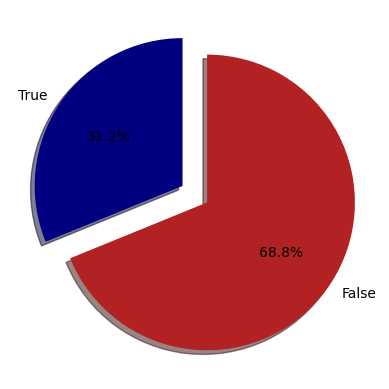

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#==============================================================================================================================
#NELA-GT-2022
#==============================================================================================================================

# Load dataset
from datasets import load_dataset
import sqlite3
#import create_engine from sqlalchemy
#from sqlalchemy import create_engine
#import pandas
import pandas as pd

#read database using create_engine
dbfile = '/content/drive/MyDrive/DATASETS/NELA-GT-2022/nela-gt-2022.db'
con = sqlite3.connect(dbfile)

# creating cursor
#cur = con.cursor()

# reading all table names
#table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
#print(table_list)

#takes about 5-6 mins due to large size of dataset
df = pd.read_sql_query("SELECT source, title, content FROM newsdata LIMIT 177866", con) #LIMIT to 10% of overall dataset (1 778 361)
#print(df)

# Be sure to close the connection
con.close()

df_labels = pd.read_csv("/content/drive/MyDrive/DATASETS/NELA-GT-2022/labels.csv", sep = ',', header=None)
df_labels = df_labels.drop(df_labels.index[0])
df_labels.columns = ['source', 'label']
#0 - reliable (TRUE), 1 - mixed (MIXED), 2 - unreliable (FALSE)
#df_labels = df_labels.drop(df_labels[df_labels['label'] == '1'].index)
df_labels.loc[df_labels.label == "0", 'label'] = "TRUE"
df_labels.loc[df_labels.label == "1", 'label'] = "MIXED"
df_labels.loc[df_labels.label == "2", 'label'] = "FALSE"
#print(df_labels)

df_merged = df.merge(df_labels, on = 'source', how = 'outer')
df_merged = df_merged.drop('source', axis=1)
df_merged = df_merged.drop(df_merged[df_merged['label'] == 'MIXED'].index)
df_merged = df_merged.rename(columns={"content": "text"})
#print(df_merged)

data = df_merged

# Label column is made of string values True/Fake, let's change it to numbers 0/1 (TRUE=1)
data['label'] = pd.get_dummies(data.label)['TRUE']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

#print(data)

df = pd.DataFrame(data)

df['text'] = df['title'] + '\n\n' + df['text']
finaldf = df[['text', 'label']]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

#Check if None values exist in rows
#null_mask = finaldf.isnull().any(axis=1)
#null_rows = finaldf[null_mask]
#print(null_rows)

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/NELA-GT-2022_final.csv", sep=',', index=False, encoding='utf-8')

#Remove 'None' again
dataset = load_dataset("csv", header=0, data_files="/content/drive/MyDrive/DATASETS/FINAL_DATASETS/NELA-GT-2022_final.csv")
dataset.set_format(type='pandas')
df = dataset['train'][:]
df = df[~df.isnull().any(axis=1)]
df.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/NELA-GT-2022_final.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
#==============================================================================================================================
#BuzzFeed - Store as CSV
#==============================================================================================================================

#Load dataset
#data = pd.read_xml('/content/drive/MyDrive/DATASETS/BuzzFeed-WebisFakeNewsCorpus2016/articls/articles')

import os
import pandas as pd
import xml.etree.ElementTree as et
df_cols= ['mainText', 'veracity']
df= pd.DataFrame([], columns=df_cols)
path='/content/drive/MyDrive/DATASETS/BuzzFeed-WebisFakeNewsCorpus2016/articles/articles/'

i = 0
df_cols= ['title','text','label']
df_final = pd.DataFrame([], columns=df_cols)

for filename in os.listdir(path):
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    xtree = et.parse(fullname)
    xroot = xtree.getroot()
    rows = []
    for record in xroot:
      mtitle = xroot.find('title').text
      mtext = xroot.find('mainText').text
      vlabel = xroot.find('veracity').text
      rows.append({"title": mtitle,"text": mtext,"label": vlabel})
    df_temp = pd.DataFrame(rows, columns = df_cols)
    df_final = pd.concat([df_final,df_temp])
    #df.to_csv('/content/drive/MyDrive/DATASETS/BuzzFeed-WebisFakeNewsCorpus2016/articles/articles_csv/'+ str(i) + '.csv', index=False)
    #i+=1

print(df_final)
df_final = df_final.drop_duplicates(subset=['text'])
print(df_final)
df_final.to_csv('/content/drive/MyDrive/DATASETS/BuzzFeed-WebisFakeNewsCorpus2016/BuzzFeed-WebisFakeNewsCorpus2016.csv', index=False)

                                                title  \
0   Judge Jeanine Pirro Destroys Any Chance Hillar...   
1   Judge Jeanine Pirro Destroys Any Chance Hillar...   
2   Judge Jeanine Pirro Destroys Any Chance Hillar...   
3   Judge Jeanine Pirro Destroys Any Chance Hillar...   
4   Judge Jeanine Pirro Destroys Any Chance Hillar...   
..                                                ...   
18  JUST IN: 50 Ex-Military & Intelligence Leaders...   
19  JUST IN: 50 Ex-Military & Intelligence Leaders...   
20  JUST IN: 50 Ex-Military & Intelligence Leaders...   
21  JUST IN: 50 Ex-Military & Intelligence Leaders...   
22  JUST IN: 50 Ex-Military & Intelligence Leaders...   

                                                 text        label  
0   Judge Jeanine Pirro has been all over Hillary ...  mostly true  
1   Judge Jeanine Pirro has been all over Hillary ...  mostly true  
2   Judge Jeanine Pirro has been all over Hillary ...  mostly true  
3   Judge Jeanine Pirro has been all ov

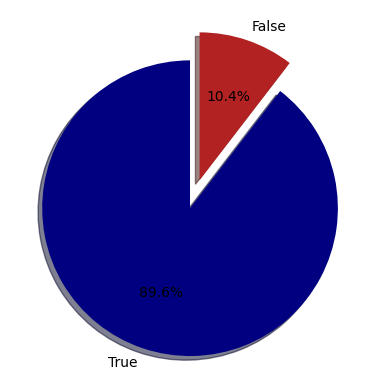

In [5]:
#==============================================================================================================================
#BuzzFeed
#==============================================================================================================================

data = pd.read_csv("/content/drive/MyDrive/DATASETS/BuzzFeed-WebisFakeNewsCorpus2016/BuzzFeed-WebisFakeNewsCorpus2016.csv", sep = ',', header=None)
data = data.drop(data.index[0])
data.columns = ['title', 'text', 'label']

#changing mostly false and no factual content labels to FALSE
data.loc[data.label == "mostly false", 'label'] = "FALSE"
data.loc[data.label == "no factual content", 'label'] = "FALSE"
#delete column with mixture of true and false (potentially this could be good data for a category 'mixed')
data = data.drop(data[data['label'] == 'mixture of true and false'].index)
#changing mostly-true label to TRUE
data.loc[data.label == "mostly true", 'label'] = "TRUE"

#print(data)

# Label column is made of string values True/Fake, let's change it to numbers 0/1 (TRUE=1)
data['label'] = pd.get_dummies(data.label)['TRUE']  #dtype=int results in 0/1 not True/False

#print(data)

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
#print(label_size)
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

df = pd.DataFrame(data)

#Change capitalized titles to sentence case (save as different csv)
df['title'] = df['title'].str.capitalize()

#merge title and text
df['text'] = df['title'] + '\n\n' + df['text']
#only text
#df['text'] = df['text']
finaldf = df[['text', 'label']]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

#finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/BuzzFeed-2016_final_only_text.csv", sep=',', index=False, encoding='utf-8')
#finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/BuzzFeed-2016_final.csv", sep=',', index=False, encoding='utf-8')
finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/BuzzFeed-2016_final_titles_sentence_case.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
#==============================================================================================================================
#ETHOS (later)
#==============================================================================================================================


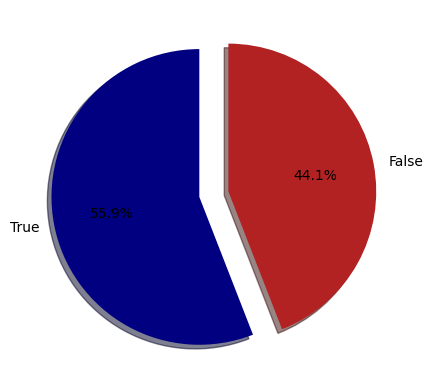

               ID  label                                               text  \
3       1633.json  False  Did not vote for tax increases as a member of ...   
5       3844.json   True  Says for the first time ever, Texas lawmakers ...   
7       7961.json   True  (T)he United States government and its Constit...   
8      10327.json   True  In the U.S. agreement with the Cuban governmen...   
9       2474.json   True  On Lee Fishers watch, almost nine out of 10 jo...   
...           ...    ...                                                ...   
12783   9785.json  False  Heroin and prescription opioids are the number...   
12784  10399.json  False  Over half the people on disability are either ...   
12785   4024.json   True  For every dollar we invest in Head Start, we g...   
12786   3518.json   True  Every child born today inherits a $30,000 shar...   
12790   9415.json   True  Graduation and third-grade reading scores are ...   

                                     subject       

In [ ]:
#==============================================================================================================================
#LIAR
#==============================================================================================================================
#Read dataset (as dataframe)
test_dataset = pd.read_csv("/content/drive/MyDrive/DATASETS/liar_dataset/test.tsv", sep = '\t', header=None)
train_dataset = pd.read_csv("/content/drive/MyDrive/DATASETS/liar_dataset/train.tsv", sep = '\t', header=None)
validate_dataset = pd.read_csv("/content/drive/MyDrive/DATASETS/liar_dataset/valid.tsv", sep = '\t', header=None)
#Merge datasets to one
data = test_dataset._append(train_dataset).sample(frac=1).reset_index().drop(columns=['index'])
data = data._append(validate_dataset).sample(frac=1).reset_index().drop(columns=['index'])
#add labels
data.columns = ['ID','label', 'text', 'subject', 'speaker', 'speaker job title', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context']
#print(data)                  #instead of 'statement' use label 'text'

#changing false and pants-fire labels to FALSE
data.loc[data.label == "pants-fire", 'label'] = "FALSE"
data.loc[data.label == "false", 'label'] = "FALSE"
#delete column with half-true or barely-true (potentially this could be good data for a category 'mixed')
#data.loc[data.label == "half-true", 'label'] = "FALSE"
#data.loc[data.label == "barely-true", 'label'] = "FALSE"
data = data.drop(data[data['label'] == 'half-true'].index)
data = data.drop(data[data['label'] == 'barely-true'].index)
#changing true and mostly-true labels to TRUE
data.loc[data.label == "true", 'label'] = "TRUE"
data.loc[data.label == "mostly-true", 'label'] = "TRUE"

#data.rename(columns = {'label':'target'}, inplace = True)

#random mixing of dataframe rows
#data = data. sample(frac=1)

#print(data)

# Label column is made of string values True/False, let's change it to numbers 0/1 (Real or TRUE=1)
data['label'] = pd.get_dummies(data.label)['TRUE']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

df = pd.DataFrame(data)
finaldf = df[["text", "label"]]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/LIAR_final.csv", sep=',', index=False, encoding='utf-8')

print(data)

       Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1               1                                                NaN   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
1  

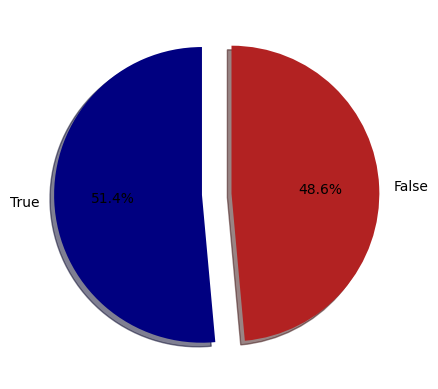

                                                    text  label
0      ARNOLD SCHWARZENEGGER Sends A Message To Liber...   True
1      WOW! “We Mexicans Need To Kill Donald Trump Be...   True
2      Jimmy Carter recovers from dehydration scare i...  False
3      2 Friars’ Mission: Reviving a Brooklyn Church ...  False
4      Boy With Autism Makes His First Friend Ever An...   True
...                                                  ...    ...
72127  Federal Judge Bars North Dakota From Enforcing...  False
72128   5 Reasons The Republicans Just Nominated The ...   True
72129  I’m Running Out of Popcorn – Harvey Organ\n\nL...   True
72131  Vanguard CEO 'encouraged' by efforts to revise...  False
72132  High School Forced to Change Mascot over Accus...  False

[63121 rows x 2 columns]


In [ ]:
#==============================================================================================================================
#WELFAKE
#==============================================================================================================================

data = pd.read_csv("/content/drive/MyDrive/DATASETS/WELFake/WELFake_Dataset.csv", sep = ',')
print(data)

#(0 = fake and 1 = real)
data.loc[data.label == 1, 'label'] = "TRUE"
data.loc[data.label == 0, 'label'] = "FALSE"

# Label column is made of string values True/False, let's change it to numbers 0/1 (Real or TRUE=1)
data['label'] = pd.get_dummies(data.label)['TRUE']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

df = pd.DataFrame(data)

df['text'] = df['title'] + '\n\n' + df['text']
finaldf = df[['text', 'label']]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

finaldf = finaldf.drop_duplicates()

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/WELFake_final.csv", sep=',', index=False, encoding='utf-8')

print(finaldf)

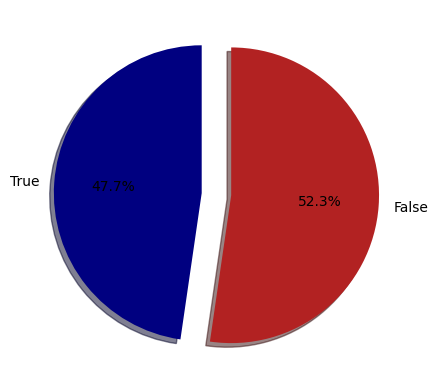

In [ ]:
#==============================================================================================================================
#clmentbisaillon - fake-and-real-news-dataset - nlp fake news detection dataset // basically ISOT
#==============================================================================================================================

# Load dataset
true_data = pd.read_csv('/content/drive/MyDrive/DATASETS/clmentbisaillon - fake-and-real-news-dataset - nlp fake news detection dataset/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/DATASETS/clmentbisaillon - fake-and-real-news-dataset - nlp fake news detection dataset/Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['label'] = ['True']*len(true_data)
fake_data['label'] = ['False']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = true_data._append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

# Label column is made of string values True/Fake, let's change it to numbers 0/1 (TRUE=1)
data['label'] = pd.get_dummies(data.label)['True']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

#print(data)

df = pd.DataFrame(data)

df['text'] = df['title'] + '\n\n' + df['text']
finaldf = df[['text', 'label']]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/clmentbisaillon_final.csv", sep=',', index=False, encoding='utf-8')

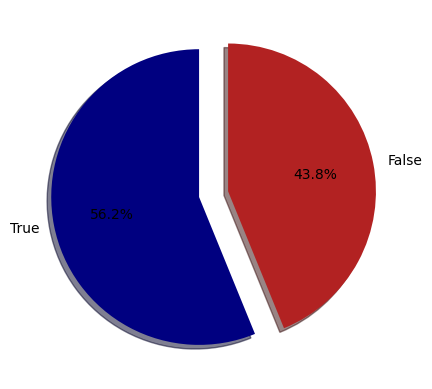

                                                    text  label
0      Says the Annies List political group supports ...  False
1      When did the decline of coal start? It started...   True
2      Hillary Clinton agrees with John McCain "by vo...   True
3      Health care reform legislation is likely to ma...  False
4      The economic turnaround started at the end of ...   True
...                                                  ...    ...
10235  There are a larger number of shark attacks in ...   True
10236  Democrats have now become the party of the [At...   True
10237  Says an alternative to Social Security that op...   True
10238  On lifting the U.S. Cuban embargo and allowing...  False
10239  The Department of Veterans Affairs has a manua...  False

[10240 rows x 2 columns]


In [ ]:
#==============================================================================================================================
#jy46604790 - fake dataset // basically LIAR
#==============================================================================================================================

data = pd.read_csv("/content/drive/MyDrive/DATASETS/jy46604790 - fake dataset/fake.csv", sep = ',')
#print(data)

data.rename(columns = {'Label':'label'}, inplace = True)
data.rename(columns = {'Statement':'text'}, inplace = True)

#changing false and pants-fire labels to FALSE
data.loc[data.label == "pants-fire", 'label'] = "FALSE"
data.loc[data.label == "false", 'label'] = "FALSE"
#delete column with half-true or barely-true (potentially this could be good data for a category 'mixed')
#data.loc[data.label == "half-true", 'label'] = "FALSE"
#data.loc[data.label == "barely-true", 'label'] = "FALSE"
data = data.drop(data[data['label'] == 'half-true'].index)
data = data.drop(data[data['label'] == 'barely-true'].index)
#changing true and mostly-true labels to TRUE
data.loc[data.label == "true", 'label'] = "TRUE"
data.loc[data.label == "mostly-true", 'label'] = "TRUE"

#data.rename(columns = {'label':'target'}, inplace = True)

#random mixing of dataframe rows
#data = data. sample(frac=1)

#print(data)

# Label column is made of string values True/False, let's change it to numbers 0/1 (Real or TRUE=1)
#data['label'] = pd.get_dummies(data.label)['TRUE']

# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['navy','firebrick'],startangle=90,shadow=True,labels=['True','False'],autopct='%1.1f%%')
plt.show()

df = pd.DataFrame(data)
finaldf = df[["text", "label"]]

finaldf = finaldf.sample(frac=1, random_state=42).reset_index(drop=True)

finaldf.dropna(subset=['text'], inplace=False)
finaldf.dropna(subset=['label'], inplace=False)
# Select Rows without NaN Values in Specific Column
#finaldf = finaldf[~finaldf['text'].isna()]
# Select Rows without NaN Values in All Columns
finaldf = finaldf[~finaldf.isnull().any(axis=1)]

finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/jy46604790_fake_dataset_final.csv", sep=',', index=False, encoding='utf-8')

print(data)

In [ ]:
#==============================================================================================================================
#jy46604790 - fake dataset with EU news // basically LIAR with EU news textual content
#==============================================================================================================================

from datasets import load_dataset

ds = load_dataset("winterForestStump/fake-news-detector-euvsdisinfo")

#print(ds)

ds = ds.rename_column("Title", "title")
ds = ds.rename_column("Summary", "text")

ds = ds['train'].add_column(name="label", column=[i for i in range(len(ds['train']))])

finaldf = ds.to_pandas()

finaldf = finaldf.assign(label=0) #Real or True = 1, False = 0 (all False for this dataset, no True available)

#print(finaldf)
#finaldf.sample(n=10)

#ds['train'].to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/jy46604790_fake_datase_EU_final.csv", sep=',', index=False, encoding='utf-8')
finaldf.to_csv("/content/drive/MyDrive/DATASETS/FINAL_DATASETS/jy46604790_fake_datase_EU_final.csv", sep=',', index=False, encoding='utf-8')

Repo card metadata block was not found. Setting CardData to empty.
